In [1]:
import glob, os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.mask
import rasterio.plot
import matplotlib.pyplot as plt
from rasterstats import zonal_stats
from pathlib import Path

print('Successfully import of all libraries !')

Successfully import of all libraries !


# Input / Output

## Input

In [2]:
ipath = '/export/projects/Sen4Stat/WorkingData/Delince_DATA_ESP/'

adm_name  = 'province'
crop_name = 'pr_8'

if adm_name == 'municipality':
    adm_limit = f'{ipath}Admin_limits_BM/ESP_SITE_2_MUNICIPALITY_32630.shp'
    adm_name_field  = 'NAMEUNIT'
elif adm_name == 'province':
    adm_limit = f'{ipath}Admin_limits_BM/ESP_SITE_2_PROVINCE_32630.shp'
    adm_name_field  = 'NAMEUNIT'
elif adm_name == 'all':
    adm_limit = f'{ipath}Admin_limits_BM/ESP_SITE_2_ALL_32630.shp'
    adm_name_field  = 'COUNTRY'

if crop_name == 'grp_1':
    crop_map  = f'{ipath}Crop_type_maps/ESP_2018_SITE_2_buf_10_LC_all_EXTENT_wall_to_wall_SEG_RATIO_100_LEVEL_grp_1_SD_25_FEAT_2_CLASSIF_RF_OpenCV_v1.tif'
    crop_nb   = 'grp_1_nb'
elif crop_name == 'pr_7':
    crop_map  = f'{ipath}Crop_type_maps/ESP_2018_SITE_2_buf_10_LC_all_EXTENT_wall_to_wall_SEG_RATIO_100_LEVEL_grp_1_SD_25_FEAT_2_CLASSIF_RF_OpenCV_v1_reclassify_pr_7_nb.tif'
    crop_nb   = 'pr_7_nb'
elif crop_name == 'pr_8':
    crop_map  = f'{ipath}Crop_type_maps/ESP_2018_SITE_2_buf_10_LC_all_EXTENT_wall_to_wall_SEG_RATIO_100_LEVEL_grp_1_SD_25_FEAT_2_CLASSIF_RF_OpenCV_v1_reclassify_pr_8_nb.tif'
    crop_nb   = 'pr_8_nb'


lut = f'{ipath}Crop_dictionnary/crop_dictionary.xlsx'

## Output

In [3]:
opath = '/export/projects/Sen4Stat/WorkingData/Delince_DATA_ESP/Count_frequency/'

Path(opath).mkdir(parents=True, exist_ok=True)


crop_count_excel = f'{opath}count_frequency_{adm_name}_{crop_name}.xlsx'

# Read vector file with `geopandas`

In [4]:
gdf = gpd.read_file(adm_limit)
gdf

,OID_,Name,Shape_Area,INSPIREID,COUNTRY,NATLEV,NATLEVNAME,NATCODE,NAMEUNIT,CODNUT1,CODNUT2,CODNUT3,geometry
0,1,CYL,None,ES.IGN.BDDAE.34074000000,ES,https://inspire.ec.europa.eu/codelist/Administ...,Provincia,34074000000,Segovia,ES4,ES41,None,MULTIPOLYGON Z (((409800.000 4594255.480 0.000...
1,1,CYL,None,ES.IGN.BDDAE.34073400000,ES,https://inspire.ec.europa.eu/codelist/Administ...,Provincia,34073400000,Palencia,ES4,ES41,None,MULTIPOLYGON Z (((341807.455 4700040.000 0.000...
2,1,CYL,None,ES.IGN.BDDAE.34072400000,ES,https://inspire.ec.europa.eu/codelist/Administ...,Provincia,34072400000,León,ES4,ES41,None,"POLYGON Z ((199980.000 4700040.000 0.000, 3097..."
3,1,CYL,None,ES.IGN.BDDAE.34070900000,ES,https://inspire.ec.europa.eu/codelist/Administ...,Provincia,34070900000,Burgos,ES4,ES41,None,MULTIPOLYGON Z (((391208.702 4700040.000 0.000...
4,1,CYL,None,ES.IGN.BDDAE.34074900000,ES,https://inspire.ec.europa.eu/codelist/Administ...,Provincia,34074900000,Zamora,ES4,ES41,None,MULTIPOLYGON Z (((305147.066 4590240.000 0.000...
5,1,CYL,None,ES.IGN.BDDAE.34074700000,ES,https://inspire.ec.europa.eu/codelist/Administ...,Provincia,34074700000,Valladolid,ES4,ES41,None,MULTIPOLYGON Z (((409800.000 4625827.238 0.000...


# Open LUT with `pandas`

1. open file
2. select usefull columns
3. drop duplicates

In [5]:
lut_df = pd.read_excel(lut)
lut_df = lut_df[[crop_nb,crop_name]].drop_duplicates()
lut_df

,pr_8_nb,pr_8
0,0,Remove
1,111,Wheat
6,112,Maize
7,113,Rice
8,114,Sorghum
9,115,Barley
11,116,Rye
12,117,Oats
13,118,Millets
16,119,Quinoa


## Create dictionary to rename the column names later

In [6]:
dict_rename = {}

for index, row in lut_df.iterrows():

    nb   = row[crop_nb]
    name = row[crop_name]

    dict_rename[nb] = f'{nb} - {name}'

dict_rename

{0: '0 - Remove',
 111: '111 - Wheat',
 112: '112 - Maize',
 113: '113 - Rice',
 114: '114 - Sorghum',
 115: '115 - Barley',
 116: '116 - Rye',
 117: '117 - Oats',
 118: '118 - Millets',
 119: '119 - Quinoa',
 121: '121 - Leafy or stem vegetables',
 122: '122 - Fruit-bearing vegetables',
 123: '123 - Root, bulb or tuberous vegetables',
 124: '124 - Mushrooms and truffles',
 141: '141 - Soya beans',
 142: '142 - Groundnuts',
 143: '143 - Other oilseed crops',
 151: '151 - Potatoes',
 152: '152 - Sweet potatoes',
 153: '153 - Cassava',
 154: '154 - Yams',
 161: '161 - Spice crops',
 162: '162 - Hops',
 17: '17 - Leguminous crops',
 181: '181 - Sugar beet',
 182: '182 - Sugar cane',
 3: '3 - Non cropland',
 192: '192 - Fibre crops',
 1931: '1931 - Medicinal, aromatic, pesticidal or similar crops',
 1941: '1941 - Flowers crops',
 1991: '1991 - Tobacco',
 2: '2 - Perennial crops'}

# Display crop map with `rasterio` and polygons with `geopandas`

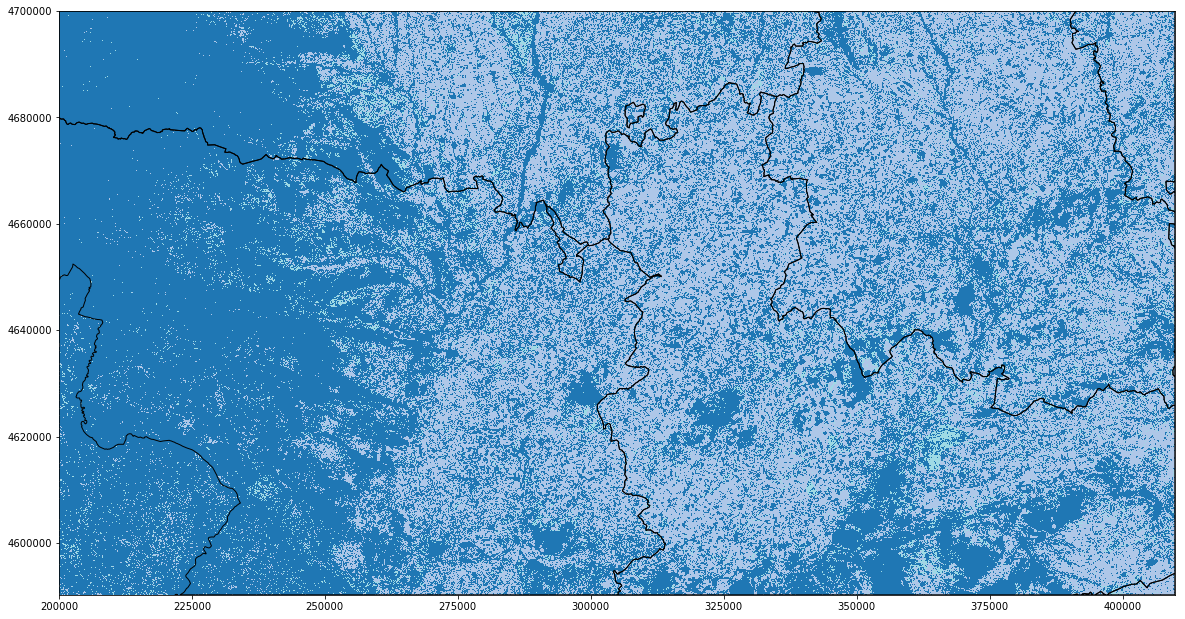

In [7]:
src = rasterio.open(crop_map, "r")

fig, ax = plt.subplots(1, figsize=(20, 20))

rasterio.plot.show(src, cmap='tab20', ax=ax)

gdf.plot(facecolor='none', edgecolor='black',ax=ax)


# Count of unique pixel values inside polygon

When working with rasters of categorical values (i.e. raster values represent discrete classes), we are often interested in the counts of unique pixel values.

In [8]:
dict_list = []

for i, row in gdf.iterrows():

    name  = row[adm_name_field]
    
    dict_freq = zonal_stats(row.geometry,
                            crop_map,
                            categorical=True,
                            category_map=dict_rename,
                            nodata=-999)[0]

    dict_freq['name'] = name

    dict_list.append(dict_freq)

print('Display the 2 first dictionaries of the list')
dict_list[0:2]

Display the 2 first dictionaries of the list


[{'2 - Perennial crops': 367,
  '3 - Non cropland': 19558,
  '17 - Leguminous crops': 8141,
  '111 - Wheat': 105397,
  '115 - Barley': 83964,
  '116 - Rye': 1872,
  '117 - Oats': 351,
  '143 - Other oilseed crops': 10962,
  '151 - Potatoes': 6275,
  '181 - Sugar beet': 9833,
  '1941 - Flowers crops': 24067,
  'name': 'Segovia'},
 {'2 - Perennial crops': 852633,
  '3 - Non cropland': 9593619,
  '17 - Leguminous crops': 6466214,
  '111 - Wheat': 11512555,
  '112 - Maize': 218082,
  '115 - Barley': 8941947,
  '116 - Rye': 18961,
  '117 - Oats': 1064761,
  '121 - Leafy or stem vegetables': 938,
  '143 - Other oilseed crops': 3508301,
  '151 - Potatoes': 18719,
  '181 - Sugar beet': 225352,
  '1941 - Flowers crops': 1938831,
  'name': 'Palencia'}]

## Convert list of dictionaries into pandas DataFrame

In [9]:
df = pd.DataFrame(dict_list).set_index('name')
df

,2 - Perennial crops,3 - Non cropland,17 - Leguminous crops,111 - Wheat,115 - Barley,116 - Rye,117 - Oats,143 - Other oilseed crops,151 - Potatoes,181 - Sugar beet,1941 - Flowers crops,112 - Maize,121 - Leafy or stem vegetables
name,,,,,,,,,,,,,
Segovia,367,19558,8141,105397,83964,1872,351,10962,6275,9833,24067,NaN,NaN
Palencia,852633,9593619,6466214,11512555,8941947,18961,1064761,3508301,18719,225352,1938831,218082.0,938.0
León,1763633,19382296,1550340,4620375,1078976,47260,1474835,1075386,103195,519871,1824169,4391868.0,625.0
Burgos,190146,682304,654213,1793635,681317,723,37001,428865,160,21661,205473,8414.0,11.0
Zamora,1940236,49466612,2870245,6644743,5306312,258978,1873444,2456774,27670,191773,2780317,1142384.0,2889.0
Valladolid,1445032,16266928,7302579,8995026,15325611,82278,567749,4231382,173002,557587,3065300,301254.0,19946.0


## Convert pandas DataFrame into Excel file

In [10]:
df.to_excel(crop_count_excel)

print(f'Excel file was created : {crop_count_excel}')

Excel file was created : /export/projects/Sen4Stat/WorkingData/Delince_DATA_ESP/Count_frequency/count_frequency_province_pr_8.xlsx
